In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = 'data/sfpd_clean.csv'
sfdata = pd.read_csv(filename)

In [3]:
sfdata.head()

,Unnamed: 0,Unnamed: 0.1,Category,Descript,DayOfWeek,PdDistrict,Address,X,Y,Location,CrimeCat,Hour,Month,Day,Year,zipcode
0,0,3,ROBBERY,"ROBBERY, BODILY FORCE",4,SOUTHERN,0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",2,21,6,16,2016,94102
1,1,6,ASSAULT,ELDER ADULT OR DEPENDENT ABUSE (NOT EMBEZZLEME...,5,NORTHERN,300 Block of FULTON ST,-122.422536,37.778796,"(37.7787958771466, -122.422536478306)",4,12,1,2,2015,94102
2,2,9,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,5,INGLESIDE,600 Block of LONDON ST,-122.437928,37.719328,"(37.7193276406568, -122.43792838007)",1,0,1,16,2015,94112
3,3,12,VEHICLE THEFT,STOLEN MOTORCYCLE,5,BAYVIEW,700 Block of SILLIMAN ST,-122.412481,37.729247,"(37.729246748441, -122.412480611343)",5,0,1,16,2015,94134
4,4,17,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,3,SOUTHERN,0 Block of FOLSOM ST,-122.390556,37.790475,"(37.7904750361645, -122.39055604599)",1,18,1,7,2015,94105


In [4]:
sfdf = sfdata.groupby(['Year', 'zipcode', 'CrimeCat'])['Unnamed: 0'].count()
sfdf = sfdf.unstack().reset_index()
sfdf.fillna(0, inplace=True)

In [5]:
sfdf.head()

CrimeCat,Year,zipcode,1,2,3,4,5,6,7,9,10
0,2003,94014,3.0,5.0,2.0,10.0,2.0,1.0,2.0,1.0,0.0
1,2003,94102,3419.0,449.0,3445.0,1759.0,696.0,503.0,474.0,75.0,33.0
2,2003,94103,3610.0,309.0,1848.0,1485.0,1207.0,568.0,424.0,97.0,35.0
3,2003,94104,229.0,29.0,16.0,79.0,40.0,20.0,46.0,1.0,2.0
4,2003,94105,666.0,29.0,53.0,136.0,217.0,76.0,79.0,7.0,4.0


In [6]:
from sklearn.preprocessing import MinMaxScaler
X = sfdf.drop(['Year', 'zipcode'], axis=1).values
scaler = MinMaxScaler()
X_sca = scaler.fit_transform(X)

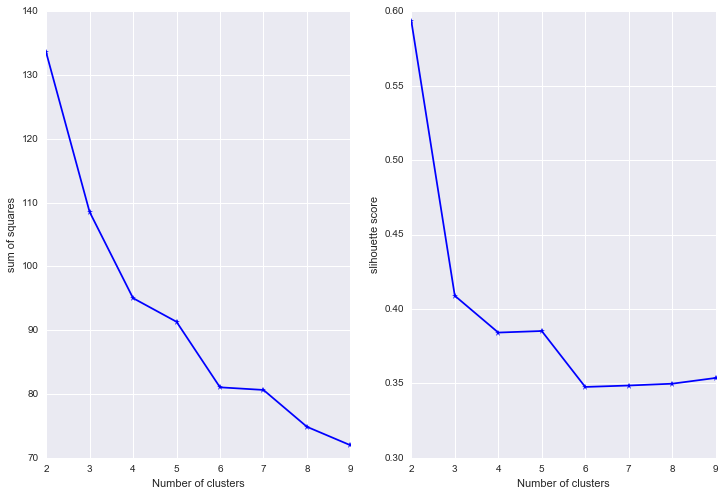

In [7]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
%matplotlib inline

scaler = StandardScaler()
X_trans = scaler.fit_transform(X)
def kmeans_all(X):
    dists = []
    scores = []
    for k in xrange(2, 10):
#         print k
        kmeanModel = KMeans(k)
        kmeanModel.fit(X)
        centroids = kmeanModel.cluster_centers_
        labels = kmeanModel.labels_
        dist = cdist(X, centroids)
        dists.append(dist.min(axis=1).sum())
        score = silhouette_score(X, labels)
        scores.append(score)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    ax1.plot(xrange(2, 10), dists, 'b*-')
    ax1.grid(True)
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('sum of squares')
    ax2 = fig.add_subplot(122)
    ax2.plot(xrange(2, 10), scores, 'b*-')
    ax2.grid(True)
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('slihouette score')
    plt.show()


def get_ref(shape, tops, bots): 
    dists = tops - bots
    ref = np.random.random(shape) * dists + bots
    return ref

def iter_kmeans(refs, k):
    vals = []
    for ref in refs:
        model = KMeans(n_clusters=k, n_init=3)
        model.fit(ref)
        vals.append(np.log(model.inertia_))
    return np.array(vals)

def gap_statistic(X, max_k=10, B=10):
    gaps = []
    gaps_minus = []
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    refs = [get_ref(X.shape, tops, bots) for i in xrange(B)]
#     print refs
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=3)
        km_act.fit(X)
        ref_log_inertias = iter_kmeans(refs, k)       
        sdk = np.std(ref_log_inertias)
#         print sdk
        gap = ref_log_inertias.mean() - np.log(km_act.inertia_)
        sk = np.sqrt(1 + 1.0/B) * sdk
#         print sk
#         print "Ref: %s   Act: %s  Gap: %s" % ( ref_inertia, km_act.inertia_, gap)
        gaps.append(gap)
        gaps_minus.append(gap - sk)
    plt.figure()
    plt.plot(range(1, max_k+1), gaps, label='Gap(k)')
    plt.plot(range(max_k), gaps_minus, label='Gap(k+1) - s(k+1)')
    plt.legend(loc='best')
    plt.show()
    return gaps

kmeans_all(X_sca)

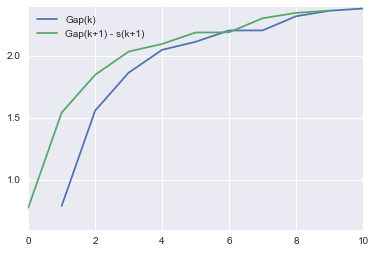

In [8]:
gaps = gap_statistic(X_sca)

In [9]:
crimes = {1: 'Theft/Larcery', 2: 'Robebery', 3: 'Nacotic/Alcochol',
          4: 'Assault', 5: 'Grand Auto Theft', 6: 'Vandalism',
          7: 'Burglary',9: 'Sex Crime', 10: 'DUI'}

def build_nmf_all(X,k):
    nmfModel = NMF(n_components=k)
    W = nmfModel.fit_transform(X)
    H = nmfModel.components_
    print 'NMF done!'
    plot_heatmap(H.T, k)
    return W, H
    

def plot_heatmap(data, k):
    fig, ax = plt.subplots(figsize = (8,8))
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(k)+0.5, minor=False, )
    ax.set_yticks(np.arange(9)+0.5, minor=False)

    # want a more natural, table-like display
#     ax.invert_yaxis()
#     ax.xaxis.tick_top()
    classLabel = ['cls-{}:'.format(i) for i in range(1, k+1)]
    ax.set_xticklabels(classLabel, minor=False)
    ax.set_yticklabels(crimes.values(), minor=False)
    ax.set_title('Heatmap of Lattent Feature')
    plt.show()

def try_different_k_class(X):
    for k in xrange(2, 11):
        build_nmf_all(X, k)

NMF done!


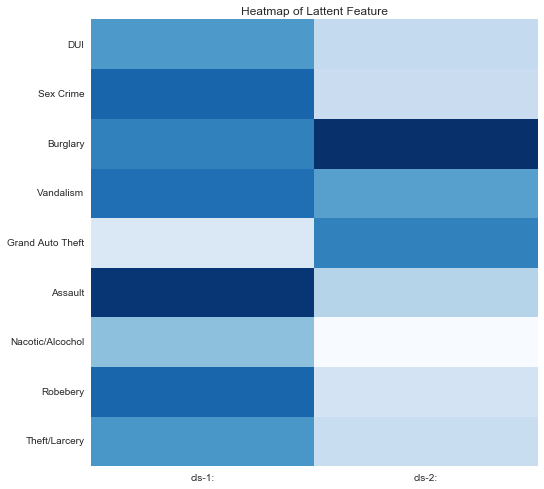

NMF done!


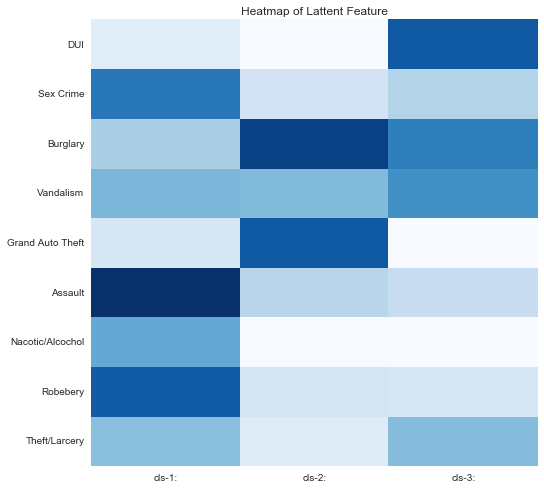

NMF done!


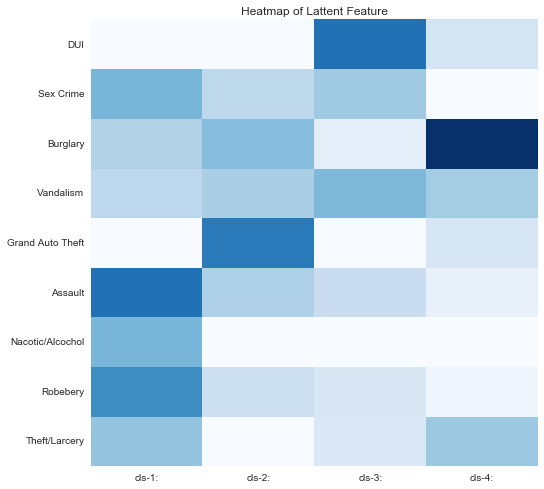

NMF done!


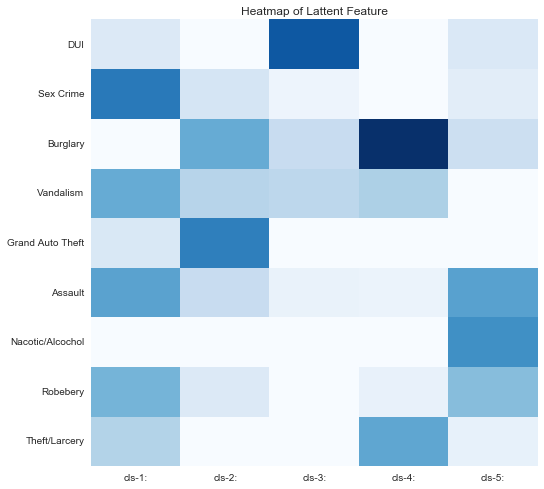

NMF done!


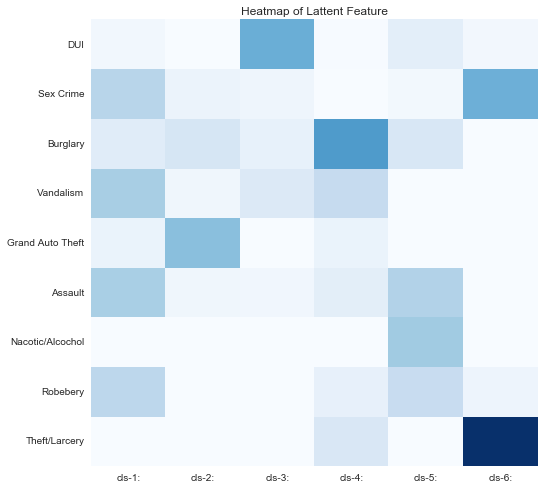

NMF done!


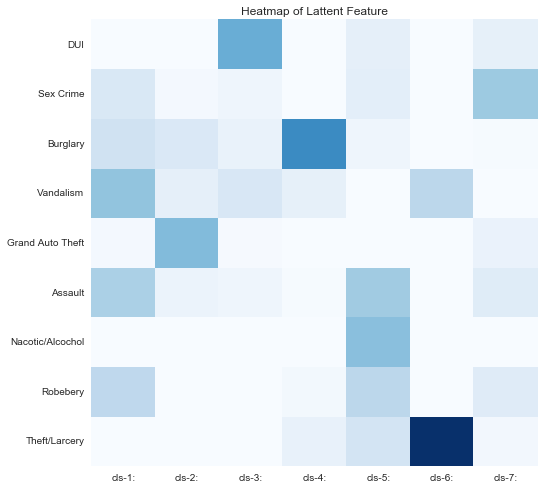

NMF done!


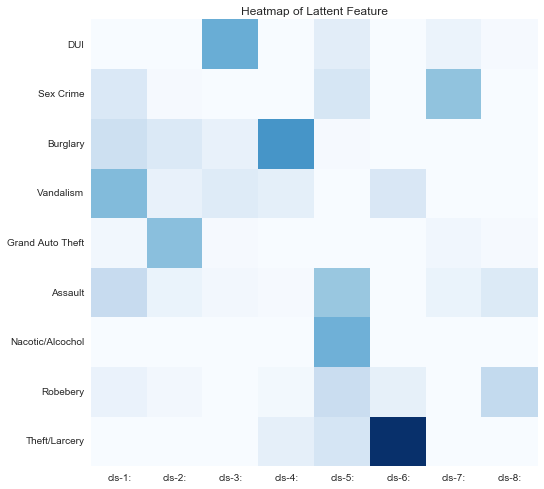

NMF done!


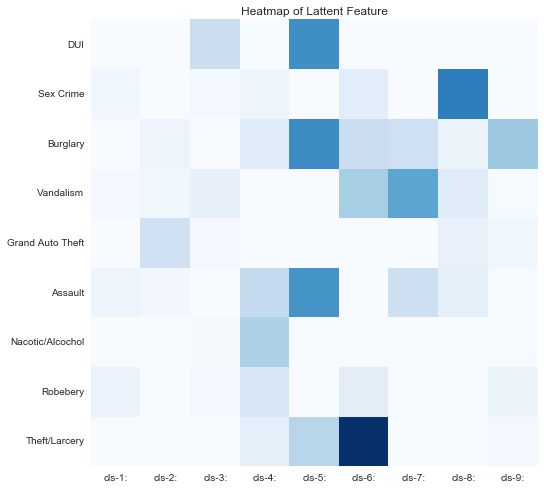

NMF done!


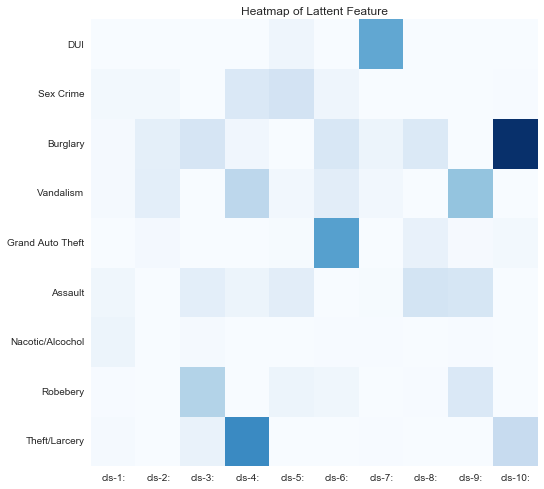

In [10]:
try_different_k_class(X_sca)

In [11]:
def build_kmean(X, k):
    model = KMeans(k, n_init=3)
    model.fit(X)
    centroids = model.cluster_centers_
    labels = model.labels_
    return centroids, labels
centroids, labels = build_kmean(X_sca, 6)
print crimes.values()
for cent in centroids:
    print cent

['Theft/Larcery', 'Robebery', 'Nacotic/Alcochol', 'Assault', 'Grand Auto Theft', 'Vandalism', 'Burglary', 'Sex Crime', 'DUI']
[ 0.13822464  0.10350427  0.03494614  0.15014259  0.10947678  0.24363517
  0.32752     0.12384106  0.37572016]
[ 0.51433384  0.64800945  0.35774963  0.81156464  0.34999726  0.65623705
  0.75591579  0.66904845  0.46881092]
[ 0.01730508  0.01263547  0.00125548  0.01718905  0.01019676  0.02545864
  0.03752577  0.01440568  0.01260023]
[ 0.21411808  0.34274476  0.10889339  0.47768449  0.32323757  0.49181281
  0.57421818  0.37281758  0.27805836]
[ 0.1822696   0.1695858   0.03114282  0.22396345  0.24284344  0.31099334
  0.46188308  0.16067244  0.1359924 ]
[ 0.10554643  0.06881336  0.01125496  0.10053331  0.09973569  0.1629967
  0.2472062   0.08306381  0.08823811]


NMF done!


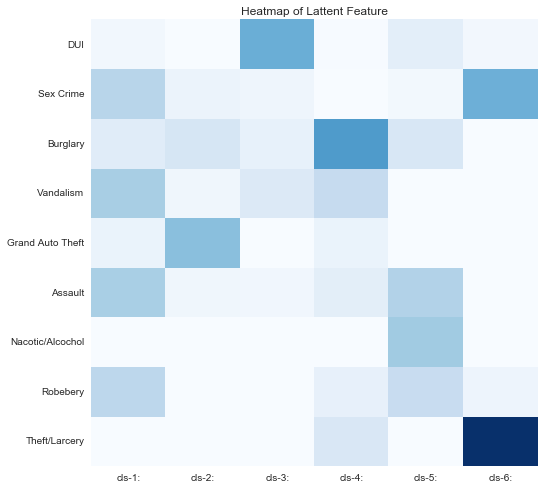

In [12]:
W, H = build_nmf_all(X_sca, 6)

In [13]:
labelsNMF = W.argmax(axis=1)

In [14]:
from mpl_toolkits.basemap import Basemap
import fiona
from shapely.geometry import shape, mapping
from pyproj import Proj, transform
from fiona.crs import from_epsg
from itertools import chain
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from matplotlib.collections import PatchCollection

SFcenter = (-122.4194, 37.7749)
# SFshapefile = 'map/SF-ZipCodes/SFZipCodes'
SFshapefile = 'map/SFFindNeighborhoods/geo_export_d66d1918-4dd9-418b-af5c-3cba0918f56b'
# SFshapefile = 'map/stclines_streets/stclines_streets'
# SFshapefile = 'map/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA'
state = 'map/Bay Area ZIP Codes/geo_export_cd2a0d4c-e556-45fa-8c0d-37dca9d7c0e4'
# shape = fiona.open(SFshapefile + '.shp')

# original = Proj(shape.crs) # EPSG:4326 in your case
# destination = Proj(init='EPSG:4326') # your new EPSG
# with fiona.open('map/SF-ZipCodes/SFZipCodes_new.shp', 'w', 'ESRI Shapefile', shape.schema.copy(), crs=from_epsg(4326)) as output:
#     for feat in shape:
#         out_linearRing = []
# #         print feat
#         for point in feat['geometry']['coordinates'][0]:
# #             if 
#             (lon, lat) = point
            
#             x,y = transform(original, destination,lon,lat)
#             print x, y
#             # change only the coordinates of the feature
#             out_linearRing.append((x,y))
#         feat['geometry']['coordinates'] = [out_linearRing]
#         output.write(feat)

(187,
 5,
 [-122.80441700099175, 37.25218999903195, 0.0, 0.0],
 [-121.4038420032024, 38.864244999689674, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x11a014bd0>)

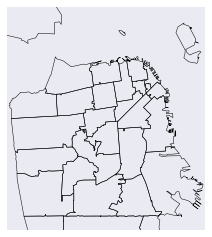

In [16]:
from shapely.geometry import box

shp = fiona.open(SFshapefile + '.shp')
bds = shp.bounds
shp.close()
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra=0.01
m = Basemap(projection='tmerc',
            lon_0=SFcenter[0],
            lat_0=SFcenter[1],
            ellps = 'WGS84',
            width = w,
            height = h,
            llcrnrlon=coords[0] - extra * w,
            llcrnrlat=coords[1] - extra + 0.01 * h,
            urcrnrlon=coords[2] + extra * w,
            urcrnrlat=coords[3] + extra + 0.01 * h,
            lat_ts=0,
            resolution='i')
m.readshapefile(state,
                'SF',
                color='black',
                zorder=2)

In [24]:
from pysal.esda.mapclassify import Natural_Breaks
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

posts = [str(x) for x in sfdf['zipcode'].unique()]

def prep_df(df, W, labels):
    W_df= W = pd.DataFrame(W)
    for col in W.columns:
        W.loc[:,col] = Natural_Breaks(W.loc[:, col], k=10).yb
    df['class'] = labels + 1
    
    df = pd.concat((df.drop(crimes.keys(), axis=1), W), axis=1)
    df['zipcode'] = df['zipcode'].apply(str)
    return df

def get_df_map(df):
    df_map = pd.DataFrame({
            'poly': [Polygon(xy) for xy in m.SF],
            'zipcode': [ward['zip'] for ward in m.SF_info]})
    df_map = df_map[df_map['zipcode'].isin(posts)]
    df_map = pd.merge(df_map, df, how='left', left_on='zipcode', right_on='zipcode',
                      left_index=True, right_index=False)
    df_map = df_map.fillna(0)
#     print df_map.head()
    return df_map

def build_yr_map_nmf(df_map):
    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='w', frame_on=True)
    # draw wards with grey outlines
    norm = Normalize()
    cmaps = []
    colors = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples', 'Greys']
    for i in xrange(5):
        color = colors[i]
        cmap = plt.get_cmap(color)
#         print i
        df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=0.2, alpha=1.0, zorder=4))
        if len(df_map[df_map['class'] == i+1]['patches']) != 0:
            pc = PatchCollection(df_map[df_map['class'] == i+1]['patches'], match_original=True, alpha=0.8)
            pc.set_facecolor(cmap(norm(df_map.loc[(df_map['class'] == i+1), i].values)))
            ax.add_collection(pc)
    if len(df_map[df_map['class'] == 0]['patches']) != 0:
        pc = PatchCollection(df_map[df_map['class'] == 0]['patches'], match_original=True, alpha=0.3)
        pc.set_facecolor('Grey')
        ax.add_collection(pc)
#     info = 'SF Commuties Categoried by Crime -- {}'.format(yr)

    # Draw a map scale
    m.drawmapscale(
        coords[0] + 0.2, coords[1] + 1.015,
        coords[0], coords[1],
        2.,
        barstyle='fancy', labelstyle='simple',
        fillcolor1='w', fillcolor2='#555555',
        fontcolor='#555555', units='mi',
        zorder=5)
    # this will set the image width to 722px at 100dpi
    plt.tight_layout()
#     fig.set_size_inches(12, 16)
    # plt.savefig('data/london_plaques.png', dpi=100, alpha=True)
    plt.show()

In [23]:
new_df = prep_df(sfdf, W, labelsNMF)

In [20]:
df_map = get_df_map(new_df[new_df['Year'] == 2003])
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', zorder=4))
df_map[df_map['class'] == 0]['patches']

Series([], Name: patches, dtype: object)

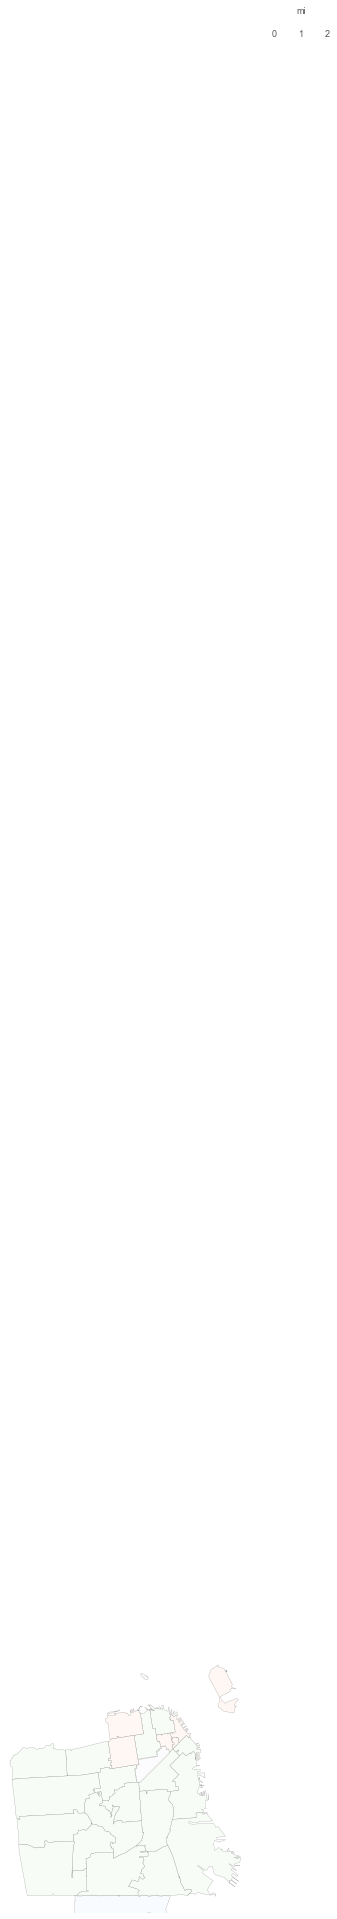

In [25]:
build_yr_map_nmf(df_map)

In [ ]:
for yr in xrange(2003, 2016):
    df_map = get_df_map(new_df[new_df['Year'] == yr])
    build_yr_map_nmf(df_map)